# Projet: Predict stock price

**Instructions**

The goal of this exercise is to build models that predict stock price the next week. In this exercice,we have to:
*  build deep learning models
* Try a model that is not in the field of deep learning like arima.
* Improve the way to check the efficacity of the models
compare the models you will build

**Approach**

We will explore 3 types of models:
- ARIMA model 
- LSTM models ( we will consider different types of lstm)
- CNN 

To check the efficacity of our models, we will use the mean squared error, mean absolute error and a metric that we design specifically for the problem.







# Useful package

In [ ]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt




<ipython-input-1-271c7b8dfcd3>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Data Processing


## Loading Data: Renault_Stock_prices 

In [ ]:

file = "https://raw.githubusercontent.com/fabnancyuhp/DEEP-LEARNING/main/DATA/RENAULT.parquet"
Renault_Stock_prices = pd.read_parquet(file)
Renault_Stock_prices = Renault_Stock_prices.loc[Renault_Stock_prices.index.year>=2018][['Close']]

Renault_Stock_prices.head()

,Close
Date,
2018-01-02,83.800003
2018-01-03,84.089996
2018-01-04,85.220001
2018-01-05,87.199997
2018-01-08,88.470001


We visualise the time serie:


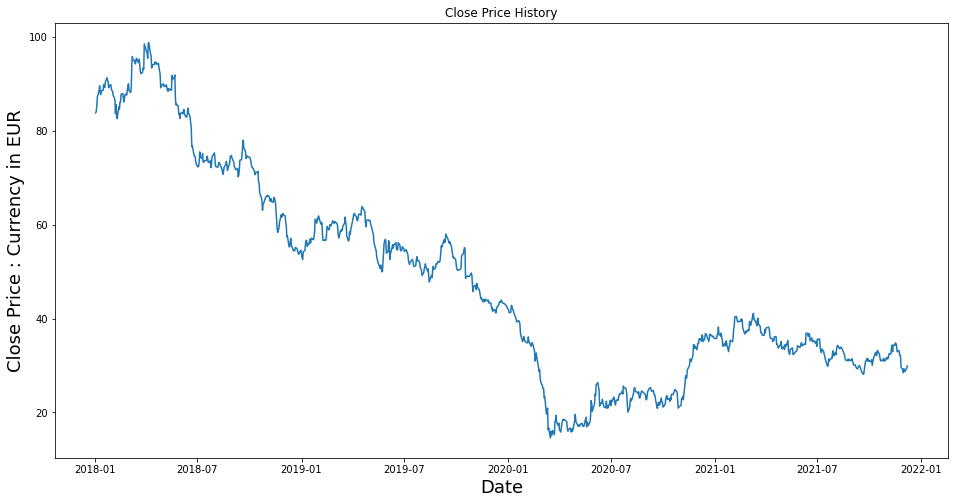

In [ ]:

plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(Renault_Stock_prices['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price : Currency in EUR',fontsize=18)
plt.show()


## Train/ test split

We have to separate the dataset in a training set and a testing set. We choose to use the data from january 2018 to august 2021 for the training and the remaining data (from august 2021 to now) for the testing.

We split the training set in a validation_training set and a validation_testing for the the optimization of the hyperparameters 


In [ ]:
# Train- test split
train = Renault_Stock_prices.loc[Renault_Stock_prices.index < '2021-08-01']
test = Renault_Stock_prices.loc[Renault_Stock_prices.index >= '2021-08-01']
# We split the train set for validation (when we optimize the hyperparamaters)
train_val=Renault_Stock_prices.loc[Renault_Stock_prices.index <= '2021-01-01']
test_val= train.loc['2021-01-01'<= train.index ]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train['Close'].values.reshape(-1,1))
train_val_scaled=sc.fit_transform(train_val['Close'].values.reshape(-1,1))


## Normalizing & preprocessing  data

###Function to create time serie Dataset

As we want to forecast the price of the option a week after, we have to preprocess the time serie to have as input the past option prices(we will denote the variable n_input) and as output the price 5 days after (As we consider only the 5 business days of the week). We use the fonction **split_sequence_bis** for this purpose.

In [ ]:
#Raw_list is a python list modelising the sequence 
#n_steps : number time steps used as input 
def split_sequence(raw_seq,n_steps):
    X = []
    y = []
    for i in range(len(raw_seq)):
        end_ix = i + n_steps
        if end_ix<=len(raw_seq)-1:
            X.append(raw_seq[i:end_ix])
            y.append(raw_seq[end_ix])
    return np.array(X),np.array(y)


def split_sequence_bis(raw_seq,n_steps,n_steps_pred):
    X = []
    y = []
    for i in range(len(raw_seq)):
        end_ix = i + n_steps 
        end_iy = i + n_steps +n_steps_pred-1
        if (end_iy<=len(raw_seq)-1):
            X.append(raw_seq[i:end_ix])
            y.append(raw_seq[end_iy])
    return np.array(X),np.array(y)

    

#Initialization of the tables of results

In [ ]:
results = pd.DataFrame(columns = ['MSE Training Error', 'MSE Testing Error','MAE Training Error', 'MAE Testing Error','M1 Training Error', 'M1 Testing Error'], 
                      index = ['ARIMA','Vanilla_LSTM', 
                               'STACKED_LSTM', 
                               'BI_LSTM','CNN', 'CNN_LSTM'])

predictions = pd.DataFrame(columns = ['Real values','ARIMA','Vanilla_LSTM', 
                               'STACKED_LSTM', 
                               'BI_LSTM','CNN', 'CNN_LSTM'],
                           index=range(len(test)) )
predictions['Real values']=test['Close'].values

## Metrics

As we are dealing with continuous variable, we use classique regression metrics such as the mean squared error and the mean absolute error. 


We design a metric specifically made for our problem. We compute the moving average of our predictions and we do the same for the real values. We compute then the mean absolute error of the moving averages. The window that we use for the moving average is 5 ( because we forecast for 5 days).

In [ ]:
def mse(y_pred, y):
  y_pred = np.array(y_pred)
  y = np.array(y)
  return np.sum((y-y_pred)**2)

def mae(y_pred, y):
  y_pred = np.array(y_pred)
  y = np.array(y)
  return np.sum(np.abs(y-y_pred))

def moving_average(data, window):
  n=window
  ret= np.cumsum(data, dtype=float)
  ret[n:]=ret[n:]-ret[:-n]
  return ret[n-1:]/n

def metric_1(y_pred, y,window):
  return mae(moving_average(y_pred,window),moving_average(y,window))

# ARIMA: Autoregressive Integrated Moving Average Model

In this part, we would like to perform univariate Time Series Forecasting.

ARIMA, short for ‘AutoRegressive Integrated Moving Average’, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

## Analysis of the time series

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df=pd.DataFrame(train_scaled, columns=['value'])

### Stationarity of the time serie

We want the serie to be stationnary because the term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models,  work best when the predictors are not correlated and are independent of each other.



One way to test whether a time series is stationary is to perform an augmented Dickey-Fuller test, which uses the following null and alternative hypotheses:

- H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

- HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.348396
p-value: 0.606751


The time serie is not stationary.

We differencing the serie to reach stationarity

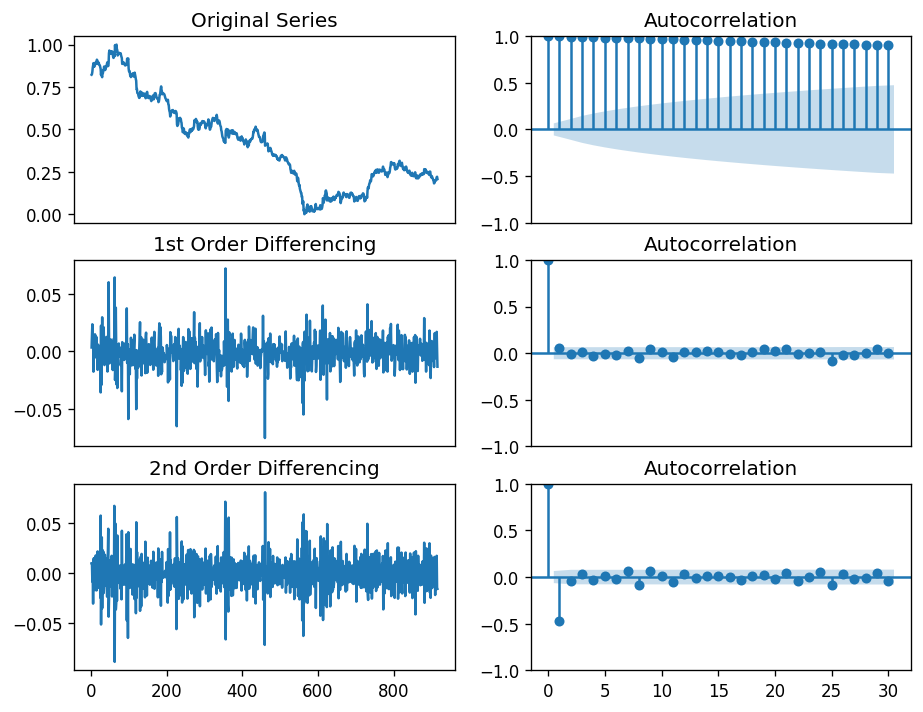

In [ ]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})



# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1,0].get_xaxis().set_visible(False)
axes[1,1].get_xaxis().set_visible(False)
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')


plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

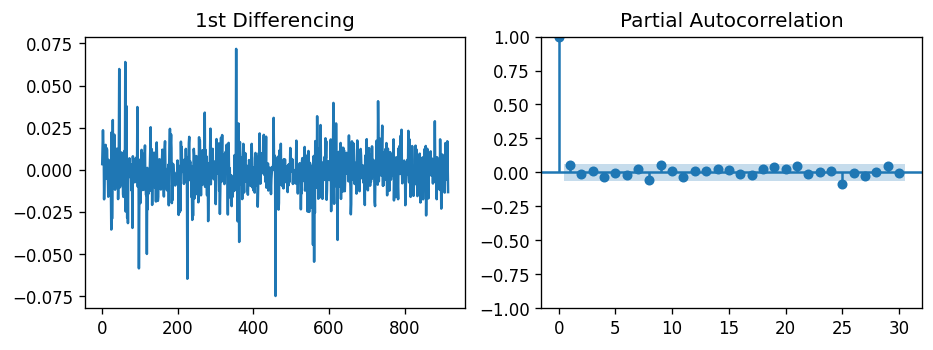

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(-0.3,0.3))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

The stationarity test shows that the serie is finally stationnary ( p-value of the test << 0.05 , the null hypothesis is rejected, hence the time serie is stationary)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -28.592372
p-value: 0.000000


### AR and AM parameters

The partial autocorrelation graph shows an autocorrelation of order 1.

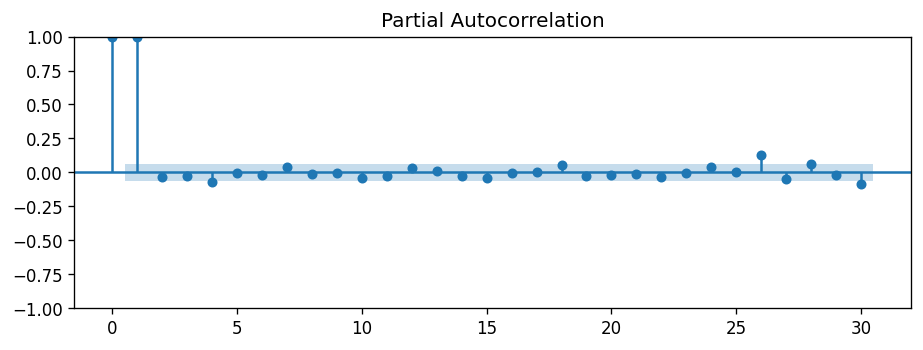

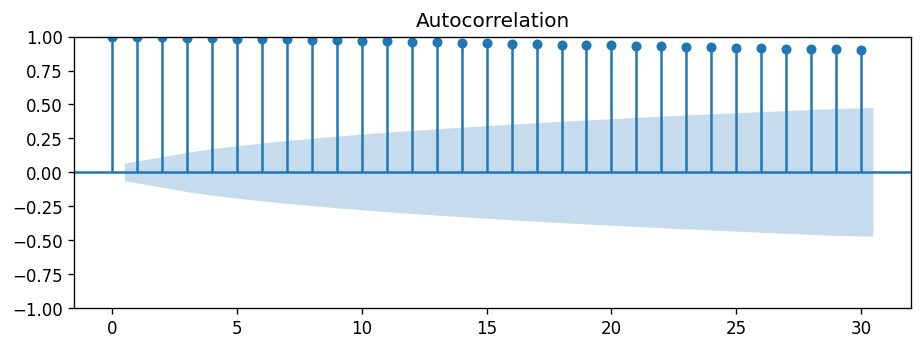

In [ ]:
plot_pacf(train_scaled);
plot_acf(train_scaled);

In [ ]:
df=pd.DataFrame(train_scaled, columns=['value'])
train_diff=df.value.diff().dropna()

We plot the autocorrelation graph of the differenced time serie to find the parameters the order of the moving average part

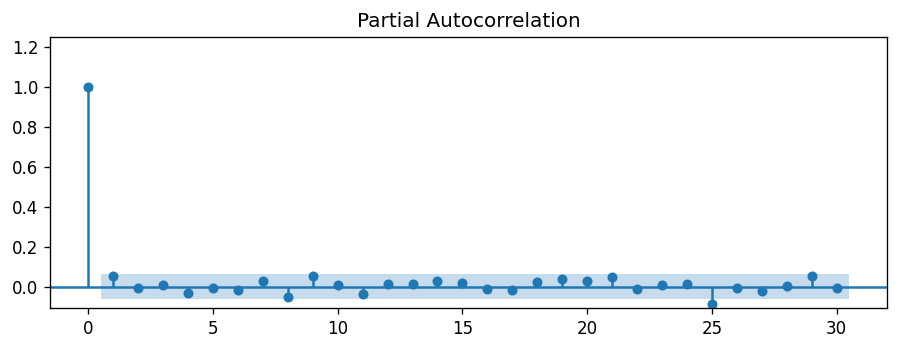

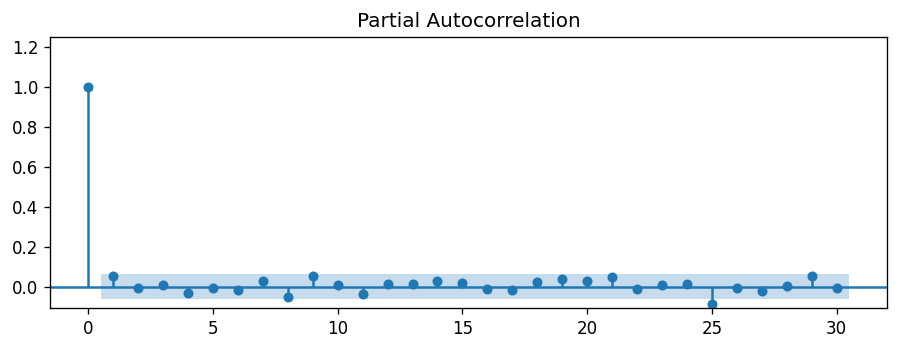

In [ ]:
plot_pacf(train_diff,auto_ylims=True)


We can conclude that the moving average part is of order at most 1.

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(train_scaled,order=(1, 1, 1))
results=model.fit()
# statistics of the model
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  916
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2709.068
Date:                Tue, 14 Mar 2023   AIC                          -5412.136
Time:                        12:51:32   BIC                          -5397.679
Sample:                             0   HQIC                         -5406.618
                                - 916                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1025      0.524     -0.196      0.845      -1.129       0.924
ma.L1          0.1574      0.519      0.303      0.762      -0.861       1.175
sigma2         0.0002   3.82e-06     41.052      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1114.12
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

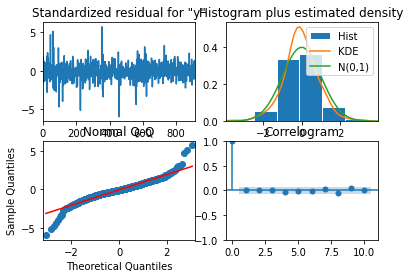

In [ ]:
results.plot_diagnostics()
plt.show()

From the summary we get the parameters for the ARIMA(1,1,1)
- coef AR= -1025
- coef_ma = 0.1574
- $\sigma^2= 0.0002$ the variance of the noise 

### Forecasting

To evaluate our model, we will use the sequence_split_bis function to separate our time serie into a input matrix and a output vector. As the parameters of our ARIMA model are (p=1,d=1,q=1), we need the data from the 2 previous day to forecast the price of the option for a day . We set the parameter n_input to 2 and the parameter n_lag to 5, since we want to predict the price for the next week.

The following function ( forecasting) forecast the option price for 5 days , only the  price of the last day is return.
the fonction take as input:
- data : it is a matrix of size n $\times$ d+ 1 (where d is the differencing parameters of the ARIMA, n is the number of prediction that we want)

  data correspond to the output of the function sequence_split_bis(test_scaled, n_input=d+1, n_lag=5)
 
- param_AR the paramater of the AR part of the ARIMA
- param_MA the parameter of the AM part of the ARIMA
- sigma2 correspond to the variance of the the noise in the MA part
- n_forecast the number of forecasting (correspond to n_lag)

In [ ]:
np.random.seed(5)
def forecasting( data, param_AR, param_MA, sigma2, n_forecast):
  n=data.shape[0]
  #differencing parameter
  d=data.shape[1]-1
  data=np.array(data).reshape(data.shape[0],data.shape[1])
  # Diffferencing data
  X =data[:,d:]-data[:,:-d]
  # MAtrice of noise for the MA part
  epsi = np.random.normal(0, np.sqrt(sigma2),(n,n_forecast+1))
  Y=  param_AR * X[:,0]+ param_MA* epsi[:,0]+ epsi[:,1]
  for i in range(1,n_forecast):
    Y=  param_AR * Y+ param_MA * epsi[:,i]+epsi[:,i+1]
  
  return Y


In [ ]:
coef_ar=-0.1025
coef_ma= 0.1574
sigma_squared=0.0002
#Creating the training and testing set
n_input=2

n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) -n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]))


y_pred_scaled=forecasting( X_test, param_AR=coef_ar, param_MA=coef_ma, sigma2=sigma_squared , n_forecast=5)
y_pred=sc.inverse_transform(y_pred_scaled.reshape(-1,1))
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=forecasting( X_train, param_AR=coef_ar, param_MA=coef_ma, sigma2=sigma_squared , n_forecast=5)
y_pred_train=sc.inverse_transform(y_pred_train_scaled.reshape(-1,1))
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['ARIMA']=y_pred

results.loc['ARIMA'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]




### Visualization

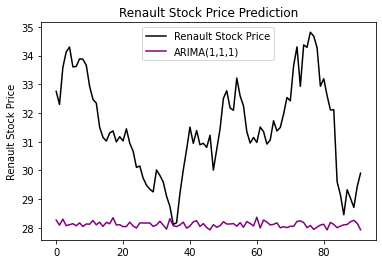

In [ ]:
plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['ARIMA'])),predictions['ARIMA'], color = 'purple', label = 'ARIMA(1,1,1)')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

# LSTM approach


## Vanilla LSTM


In [ ]:
#Loading Keras LSTM and Other Modules
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import mean_squared_error

### Optimizing the parameter n_input

In [ ]:

score_n_input=list()


# We creat a for loop to optimize the parameter n_input
for n_input in range(1,41):

  #Creating the training and testing set
  n_features=1
  n_lag=5
  test_val_scaled = sc.fit_transform(train[len(train) - len(test_val) - n_input-n_lag+1:].values.reshape(-1,1))
  X_val_train, y_val_train = split_sequence_bis(train_val_scaled,n_input,n_lag)
  X_val_test, y_val_test = split_sequence_bis(test_val_scaled,n_input,n_lag)
  X_val_train = X_val_train.reshape((X_val_train.shape[0],X_val_train.shape[1],n_features))
  X_val_test = X_val_test.reshape((X_val_test.shape[0],X_val_test.shape[1],n_features))


  #Building the Vanilla LSTM 
  Vanilla_LSTM = Sequential()
  Vanilla_LSTM.add(LSTM(units = 256,input_shape=(X_val_train.shape[1],1)))
  Vanilla_LSTM.add(Dense(1))


  #Compile the model
  #opt = RMSprop(lr=0.0001)
  Vanilla_LSTM.compile(optimizer = 'adam', loss = 'mse')

  #Train the model
  Vanilla_LSTM.fit(X_val_train,y_val_train,epochs = 300,verbose=0)
  y_pred_scaled=Vanilla_LSTM.predict(X_val_test)
  y_pred=sc.inverse_transform(y_pred_scaled)
  score_n_input.append(mean_squared_error(y_pred,y_val_test))


5/5 [==============================] - 0s 3ms/step


In [ ]:
n_input=list(range(1,41))[score_n_input.index(min(score_n_input))]
print('The optimal number of input is :',n_input)


The optimal number of input is : 28


### We train the model with the optimal parameter n_input


In [ ]:
#Creating the training and testing set
n_input=28
n_features=1
n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))


#Building the Vanilla LSTM 
Vanilla_LSTM = Sequential()
Vanilla_LSTM.add(LSTM(units = 256,input_shape=(X_train.shape[1],1)))
Vanilla_LSTM.add(Dense(1))


#Compile the model
#opt = RMSprop(lr=0.0001)
Vanilla_LSTM.compile(optimizer = 'adam', loss = 'mse',metrics=['mse'])

#Train the model
Vanilla_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)
y_pred_scaled=Vanilla_LSTM.predict(X_test)
y_pred=sc.inverse_transform(y_pred_scaled)
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=Vanilla_LSTM.predict(X_train)
y_pred_train=sc.inverse_transform(y_pred_train_scaled)
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['Vanilla_LSTM']=y_pred

results.loc['Vanilla_LSTM'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]



28/28 [==============================] - 0s 2ms/step


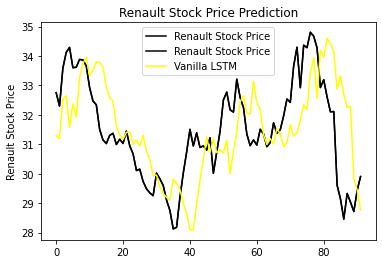

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(y_test)),sc.inverse_transform(y_test), color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['Vanilla_LSTM'])),predictions['Vanilla_LSTM'], color = 'yellow', label = 'Vanilla LSTM')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

## Stacked LSTM: Multi hidden LSTM



### Optimizing the parameter n_input

In [ ]:
#Loading Keras LSTM and Other Modules
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
score_n_input=list()


In [ ]:


# We creat a for loop to optimize the parameter n_input
for n_input in range(1,41):

  #Creating the training and testing set
  n_features=1
  n_lag=5
  test_val_scaled = sc.fit_transform(train[len(train) - len(test_val) - n_input-n_lag+1:].values.reshape(-1,1))
  X_val_train, y_val_train = split_sequence_bis(train_val_scaled,n_input,n_lag)
  X_val_test, y_val_test = split_sequence_bis(test_val_scaled,n_input,n_lag)
  X_val_train = X_val_train.reshape((X_val_train.shape[0],X_val_train.shape[1],n_features))
  X_val_test = X_val_test.reshape((X_val_test.shape[0],X_val_test.shape[1],n_features))

  # Building the stacked LSTM
  STACKED_LSTM = Sequential()
  STACKED_LSTM.add(LSTM(units = 50,activation='relu',input_shape=(X_val_train.shape[1],1),return_sequences=True))
  STACKED_LSTM.add(LSTM(units = 50,activation='relu'))
  STACKED_LSTM.add(Dense(1))


  #Compile the model
  opt = RMSprop(lr=0.0001)
  STACKED_LSTM.compile(optimizer = 'adam', loss = 'mse')

  #Train the model
  STACKED_LSTM.fit(X_val_train,y_val_train,epochs = 300,verbose=0)
  y_pred_scaled=STACKED_LSTM.predict(X_val_test)
  y_pred=sc.inverse_transform(y_pred_scaled)
  score_n_input.append(mean_squared_error(y_pred,y_val_test))

In [ ]:
n_input=list(range(1,41))[score_n_input.index(min(score_n_input))]
print('The optimal number of input is :',n_input)

The optimal number of input is : 28


### We train the model with the optimal parameter n_input

In [ ]:
#Creating the training and testing set
n_input=28
n_features=1
n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))



#Building the Stacked LSTM 
STACKED_LSTM = Sequential()
STACKED_LSTM.add(LSTM(units = 50,activation='relu',input_shape=(X_train.shape[1],1),return_sequences=True))
STACKED_LSTM.add(LSTM(units = 50,activation='relu'))
STACKED_LSTM.add(Dense(1))


#Compile the model
opt = RMSprop(lr=0.0001)
STACKED_LSTM.compile(optimizer = 'adam', loss = 'mse')

#Train STACKED_LSTM                 
STACKED_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)

#Train the model
STACKED_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)
y_pred_scaled=STACKED_LSTM.predict(X_test)
y_pred=sc.inverse_transform(y_pred_scaled)
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=STACKED_LSTM.predict(X_train)
y_pred_train=sc.inverse_transform(y_pred_train_scaled)
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['STACKED_LSTM']=y_pred

results.loc['STACKED_LSTM'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]


28/28 [==============================] - 0s 9ms/step


### Visualization

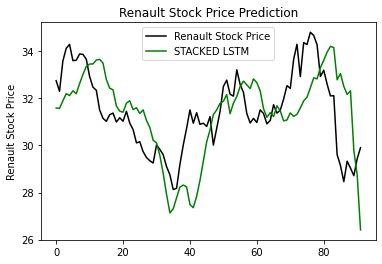

In [ ]:
plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['STACKED_LSTM'])),predictions['STACKED_LSTM'], color = 'green', label = 'STACKED LSTM')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

# Bidirectionnal LSTM 

### Optimizing the parameter n_input

In [ ]:
from tensorflow.keras.layers import Bidirectional

In [ ]:
# We creat a for loop to optimize the parameter n_input
for n_input in range(1,41):

  #Creating the training and testing set
  n_features=1
  n_lag=5
  test_val_scaled = sc.fit_transform(train[len(train) - len(test_val) - n_input-n_lag+1:].values.reshape(-1,1))
  X_val_train, y_val_train = split_sequence_bis(train_val_scaled,n_input,n_lag)
  X_val_test, y_val_test = split_sequence_bis(test_val_scaled,n_input,n_lag)
  X_val_train = X_val_train.reshape((X_val_train.shape[0],X_val_train.shape[1],n_features))
  X_val_test = X_val_test.reshape((X_val_test.shape[0],X_val_test.shape[1],n_features))

 #Building the BI_LSTM 

  BI_LSTM = Sequential()
  BI_LSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_val_train.shape[1],1)))
  BI_LSTM.add(Dense(1))
  # Compile BI_LSTM
  BI_LSTM.compile(optimizer='adam', loss='mse')

  #Train the model
  BI_LSTM.fit(X_val_train,y_val_train,epochs = 300,verbose=0)
  y_pred_scaled=BI_LSTM.predict(X_val_test)
  y_pred=sc.inverse_transform(y_pred_scaled)
  score_n_input.append(mean_squared_error(y_pred,y_val_test))

5/5 [==============================] - 0s 3ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 4ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 5ms/step


5/5 [==============================] - 0s 5ms/step


In [ ]:
n_input=list(range(1,41))[score_n_input.index(min(score_n_input))]
print('The optimal number of input is :',n_input)

The optimal number of input is : 28


### We train the model with the optimal paramater of n_input

In [ ]:
#Creating the training and testing set
n_input=28
n_features=1
n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))


#Building the BI_LSTM 
BI_LSTM = Sequential()
BI_LSTM.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1],1)))
BI_LSTM.add(Dense(1))

# Compile BI_LSTM
BI_LSTM.compile(optimizer='adam', loss='mse')

#Train the model
BI_LSTM.fit(X_train,y_train,epochs = 300,verbose=0)
y_pred_scaled=BI_LSTM.predict(X_test)
y_pred=sc.inverse_transform(y_pred_scaled)
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=BI_LSTM.predict(X_train)
y_pred_train=sc.inverse_transform(y_pred_train_scaled)
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['BI_LSTM']=y_pred

results.loc['BI_LSTM'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]


28/28 [==============================] - 0s 9ms/step


### Visualization

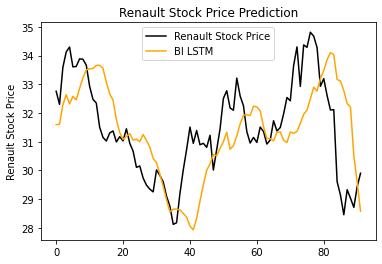

In [ ]:
plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['BI_LSTM'])),predictions['BI_LSTM'], color = 'orange', label = 'BI LSTM')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

# CNN approach 


### Optimization of the parameter n_input

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

for n_input in range(1,41):

  #Creating the training and testing set
  n_features=1
  n_lag=5
  test_val_scaled = sc.fit_transform(train[len(train) - len(test_val) - n_input-n_lag+1:].values.reshape(-1,1))
  X_val_train, y_val_train = split_sequence_bis(train_val_scaled,n_input,n_lag)
  X_val_test, y_val_test = split_sequence_bis(test_val_scaled,n_input,n_lag)
  X_val_train = X_val_train.reshape((X_val_train.shape[0],X_val_train.shape[1],n_features))
  X_val_test = X_val_test.reshape((X_val_test.shape[0],X_val_test.shape[1],n_features))

  #Building the CNN model 
  CNN_MODEL = Sequential()
  CNN_MODEL.add(Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=(X_val_train.shape[1],1)))
  CNN_MODEL.add(MaxPooling1D(pool_size=2))
  CNN_MODEL.add(Flatten())
  CNN_MODEL.add(Dense(50,activation='relu'))
  CNN_MODEL.add(Dense(1))

  #Compile the model
  CNN_MODEL.compile(optimizer = 'adam', loss = 'mse')

  #Train the model
  CNN_MODEL.fit(X_val_train,y_val_train,epochs = 1000,verbose=0,validation_split=0.1)
  y_pred_scaled=CNN_MODEL.predict(X_val_test)
  y_pred=sc.inverse_transform(y_pred_scaled)
  score_n_input.append(mean_squared_error(y_pred,y_val_test))




5/5 [==============================] - 0s 5ms/step


In [ ]:
n_input=list(range(1,41))[score_n_input.index(min(score_n_input))]
print('The optimal number of input is :',n_input)

The optimal number of input is : 16


### We train the model with the optimal parameter n_input

In [ ]:
#Creating the training and testing set
n_input=16
n_features=1
n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))


#Building the CNN model 
CNN_MODEL = Sequential()
CNN_MODEL.add(Conv1D(filters=64,kernel_size=2,activation='relu',input_shape=(X_train.shape[1],1)))
CNN_MODEL.add(MaxPooling1D(pool_size=2))
CNN_MODEL.add(Flatten())
CNN_MODEL.add(Dense(50,activation='relu'))
CNN_MODEL.add(Dense(1))

#Compile the model
CNN_MODEL.compile(optimizer = 'adam', loss = 'mse')

#Train the model
CNN_MODEL.fit(X_train,y_train,epochs = 1000,verbose=0,validation_split=0.1)
y_pred_scaled=CNN_MODEL.predict(X_test)
y_pred=sc.inverse_transform(y_pred_scaled)
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=CNN_MODEL.predict(X_train)
y_pred_train=sc.inverse_transform(y_pred_train_scaled)
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['CNN']=y_pred

results.loc['CNN'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]






28/28 [==============================] - 0s 1ms/step


### Visualization

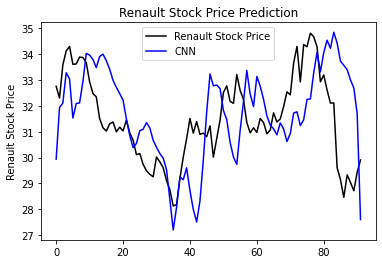

In [ ]:
plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['CNN'])),predictions['CNN'], color = 'blue', label = 'CNN')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

## CNN LSTM

### Optimisation of the parameter n_input

In [ ]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
for n_input in range(1,41):

  #Creating the training and testing set
  n_features=1
  n_lag=5
  test_val_scaled = sc.fit_transform(train[len(train) - len(test_val) - n_input-n_lag+1:].values.reshape(-1,1))
  X_val_train, y_val_train = split_sequence_bis(train_val_scaled,n_input,n_lag)
  X_val_test, y_val_test = split_sequence_bis(test_val_scaled,n_input,n_lag)
  X_val_train = X_val_train.reshape((X_val_train.shape[0],X_val_train.shape[1],n_features))
  X_val_test = X_val_test.reshape((X_val_test.shape[0],X_val_test.shape[1],n_features))

 #Building the CNN_LSTM 

  CNN_LSTM= Sequential()
  CNN_LSTM.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,X_val_train.shape[1],1)))
  CNN_LSTM.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  CNN_LSTM.add(TimeDistributed(Flatten()))
  CNN_LSTM.add(LSTM(50, activation='relu'))
  CNN_LSTM.add(Dense(1))
  # Compile CNN_LSTM
  CNN_LSTM.compile(optimizer = 'adam', loss = 'mse')
  #Train the model
  X_val_train2 = X_val_train.reshape((X_val_train.shape[0],1,X_val_train.shape[1],1))
  CNN_LSTM.fit(X_val_train2,y_train,epochs = 1000,verbose=0,validation_split=0.1)
  X_val_test2 = X_val_test.reshape((X_val_test.shape[0],1,X_val_test.shape[1],1))
  y_pred_scaled=CNN_LSTM.predict(X_val_test2)
  y_pred=sc.inverse_transform(y_pred_scaled)
  score_n_input.append(mean_squared_error(y_pred,y_val_test))


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 6ms/step


5/5 [==============================] - 0s 8ms/step


In [ ]:
n_input=list(range(1,41))[score_n_input.index(min(score_n_input))]
print('The optimal number of input is :',n_input)

The optimal number of input is : 16


### We create a model with the optimal parameter n_input




In [ ]:
#Creating the training and testing set
n_input=16
n_features=1
n_lag=5
test_scaled = sc.fit_transform(Renault_Stock_prices[len(Renault_Stock_prices) - len(test) - n_input-n_lag+1:].values.reshape(-1,1))
X_train, y_train = split_sequence_bis(train_scaled,n_input,n_lag)
X_test, y_test = split_sequence_bis(test_scaled,n_input,n_lag)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],n_features))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],n_features))


#Building the CNN_LSTM 

CNN_LSTM = Sequential()
CNN_LSTM.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,X_train.shape[1],1)))
CNN_LSTM.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNN_LSTM.add(TimeDistributed(Flatten()))
CNN_LSTM.add(LSTM(50, activation='relu'))
CNN_LSTM.add(Dense(1))

# Compile CNN_LSTM
CNN_LSTM.compile(optimizer = 'adam', loss = 'mse')
#Train the model

X_train2 = X_train.reshape((X_train.shape[0],1,X_train.shape[1],1))
  


#Train the model
CNN_LSTM.fit(X_train2, y_train,epochs = 1000,verbose=0,validation_split=0.1)
X_test2 = X_test.reshape((X_test.shape[0],1,X_test.shape[1],1))
y_pred_scaled=CNN_LSTM.predict(X_test2)
y_pred=sc.inverse_transform(y_pred_scaled)
test_error_mse=mean_squared_error(y_pred,y_test)
test_error_mae=mae(y_pred,y_test)
test_error_m1=metric_1(y_pred,y_test,n_lag)

y_pred_train_scaled=CNN_LSTM.predict(X_train2)
y_pred_train=sc.inverse_transform(y_pred_train_scaled)
train_error_mse=mean_squared_error(y_pred_train,y_train)
train_error_mae=mae(y_pred_train,y_train)
train_error_m1=metric_1(y_pred_train,y_train,n_lag)
predictions['CNN_LSTM']=y_pred

results.loc['CNN_LSTM'] = [train_error_mse,test_error_mse,train_error_mae,test_error_mae,train_error_m1,test_error_m1]





28/28 [==============================] - 0s 4ms/step


### Visualization

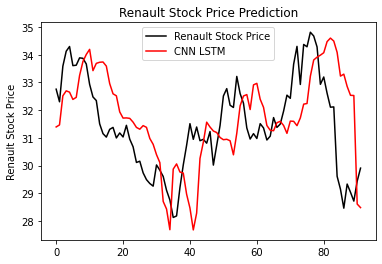

In [ ]:

plt.plot(range(len(test['Close'])),test['Close'], color = 'black', label = 'Renault Stock Price')
plt.plot(range(len(predictions['CNN_LSTM'])),predictions['CNN_LSTM'], color = 'red', label = 'CNN LSTM')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()

# Results

We show the table of mean scared error of the training set and for the testing test for each model.

In [ ]:
print(results)

             MSE Training Error MSE Testing Error MAE Training Error  \
ARIMA                767.916359        763.225202       25216.006448   
Vanilla_LSTM         975.611392        975.577358       27557.575605   
STACKED_LSTM         973.344667         962.97089       27528.611144   
BI_LSTM              980.208361        962.283886       27625.811059   
CNN                  956.779718         979.77088       27671.829914   
CNN_LSTM             949.086322        982.356385       27565.159744   

             MAE Testing Error M1 Training Error M1 Testing Error  
ARIMA              2541.524154       25105.80992      2430.727854  
Vanilla_LSTM       2870.403104      27429.817504      2748.967925  
STACKED_LSTM       2850.697739      27400.471257      2731.950157  
BI_LSTM            2850.806662       27497.86073      2729.282905  
CNN                2875.462078      27545.232041      2753.706639  
CNN_LSTM           2880.094009      27438.947748      2758.713551  


We can do several remarks on this table of results:
- The ARIMA model is the one minimizing the risk, but when we look at the graph it seems that the model is a stationary model with a little bit of noise. It doesn't follow the trend that we can observe on the real values.
- The MAE penalize less the big gap between predictions and real values than MSE but we have more or less the same conclusions: LSTMs are better than CNNs
- The Bidirectionnal LSTM seems to be the best deep learning model

Conclusion: To evaluate the forecasting abilities of a model, it is necessary to have a visual appreciation when we deal with time series data: Predicting shifts of trend is as important as predicting the correct value. 

The metrics are useful to choose between two models that are more or less detecting the same trend shifts.

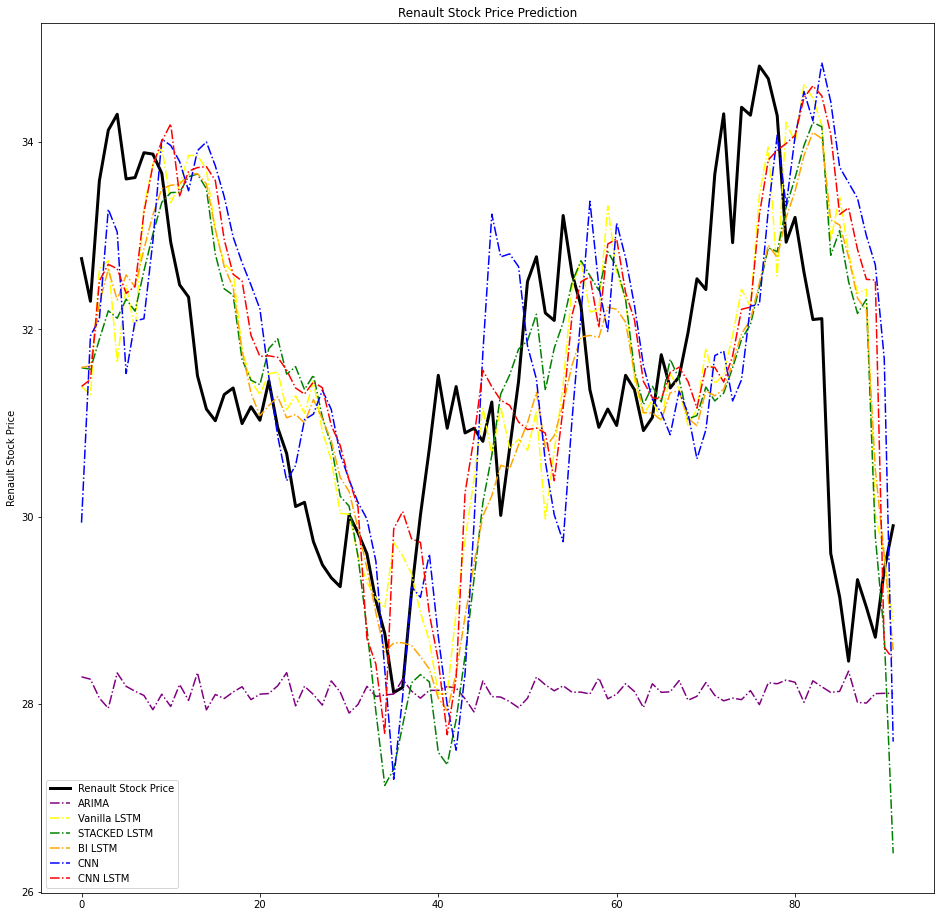

In [ ]:
# Plot of the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.plot(range(len(test['Close'])),test['Close'], color = 'black', linewidth=3,label = 'Renault Stock Price')
plt.plot(range(len(predictions['ARIMA'])),predictions['ARIMA'], color = 'purple',linestyle = 'dashdot', label = 'ARIMA')
plt.plot(range(len(predictions['Vanilla_LSTM'])),predictions['Vanilla_LSTM'], color = 'yellow',linestyle = 'dashdot',  label = 'Vanilla LSTM')
plt.plot(range(len(predictions['STACKED_LSTM'])),predictions['STACKED_LSTM'], color = 'green',linestyle = 'dashdot',  label = 'STACKED LSTM')
plt.plot(range(len(predictions['BI_LSTM'])),predictions['BI_LSTM'], color = 'orange',linestyle = 'dashdot',  label = 'BI LSTM')
plt.plot(range(len(predictions['CNN'])),predictions['CNN'], color = 'blue',linestyle = 'dashdot',  label = 'CNN')
plt.plot(range(len(predictions['CNN_LSTM'])),predictions['CNN_LSTM'], color = 'red',linestyle = 'dashdot',  label = 'CNN LSTM')
plt.title('Renault Stock Price Prediction')
plt.ylabel('Renault Stock Price')
plt.legend()
plt.show()
